## A statistical test

In this notebook we develop some more rigourous statistical tests around the efficient market hypothesis. 

Here we are attempting to falsify the null hypothsis, that that the daily market value changes are uncorrelated.

white noise as “uncorrelated”, which means that each value is independent of the others, and Brownian noise as “correlated”, because each value depends on the preceding value. 

In a Brownian noise signal, each value is the sum of the previous value and a random “step”, so we expect a strong serial correlation:

A martingale is a sequence of random variables (i.e., a stochastic process) for which, at a particular time in the realized sequence, the expectation of the next value in the sequence is equal to the present observed value even given knowledge of all prior observed values.

A necessary (but not sufficient) condition for the martingale hypothesis to hold is that the time series has no
autocorrelation, also known as serial correlation, of any order. Note that autocorrelation is sensitive only to linear
relationships

First, consider the relevant literature on the dependence of stock market returns. Fama (1970) found that 22
out of the 30 stocks of the DJIA exhibited positive daily serial correlation. 

Returns, rather than price are often used, are used as some of the statistical tests require a stationary variable. 

the runs test, a non-parametric statistical test that can be
used to test for serial dependence, a lack of dependence being a necessary (but not sufficient) condition for the
martingale hypothesis to hold. In contrast to autocorrelation, the runs test loses information because the magnitude
of the returns is lost. However, whilst autocorrelation can detect only linear relationships, the runs test can detect
both linear and non-linear relationships.

If the number of runs is significantly higher or lower than expected, the hypothesis of statistical independence
may be rejected. Consider the DJIA closing prices. There is no need to detrend the data. A run is a consecutive
sequence of returns above (below) the mean return. The above runs test is performed on daily, weekly, monthly and
annual returns, in chronological order.

 so-called runs-test also called Wald–Wolfowitz test [3,4]. This is a non-parametric test in which the null-hypothesis stating that the sequence gets produced in random fashion gets tested against the alternative hypothesis stating the opposite -- i.e., produced randomly. In detail, the null-hypothesis gets rejected in case of systematic or clustered arrangement of variables in a sequence. The test is called runs-test as it works with runs in a series -- e.g., the sequence "ABBC" has the three runs "A", "BB" and "C". Nonetheless, this test is only designed to work with dichotomous (binary) observations which is not the case in my sequences.


In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
data = numpy.loadtxt('nasdaq.csv')
follow = data[:-1] < data[1:]
seq = follow[:-1] == follow[1:]


## Autocorrelation

In [6]:
def serial_corr(sig, lag=1):
    n = len(sig)
    y1 = sig[lag:]
    y2 = sig[:n-lag]
    corr = np.corrcoef(y1, y2, ddof=0)[0, 1]
    return corr

In [9]:
serial_corr(follow,  lag=1)

0.11479420079763919

In [13]:
coors = []
for i in range(1, 30):
    coors.append(serial_corr(follow,  lag=i))

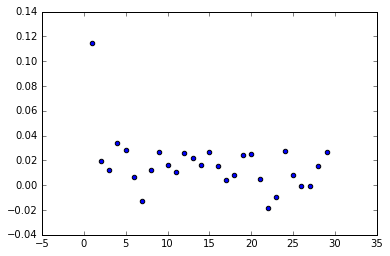

In [15]:
plt.scatter(range(1, 30), coors)

In [16]:
#test on random data
test = np.random.randint(0,2,len(follow))
serial_corr(test)

-0.0057543069496796655

In [17]:
coors = []
for i in range(1, 30):
    coors.append(serial_corr(test,  lag=i))

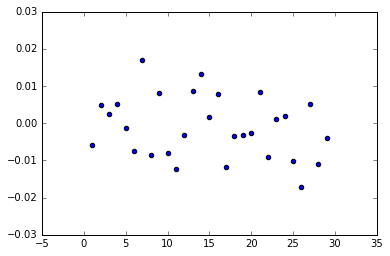

In [18]:
plt.scatter(range(1, 30), coors)

## Runs test

In [19]:
#It detects where chunks begin, has some logic for the first and last chunk, 
#and simply computes differences between chunk starts and discards lengths corresponding to False chunks.

runs = np.diff(np.where(np.concatenate(([follow[0]],
                                     follow[:-1] != follow[1:],
                                     [True])))[0])[::2]

In [20]:
runs = np.diff(np.where(follow[:-1] != follow[1:]))

(array([  3.41700000e+03,   1.09400000e+03,   3.36000000e+02,
          1.24000000e+02,   1.70000000e+01,   2.20000000e+01,
          7.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          2.00000000e+00]),
 array([  1. ,   2.8,   4.6,   6.4,   8.2,  10. ,  11.8,  13.6,  15.4,
         17.2,  19. ]),
 <a list of 10 Patch objects>)

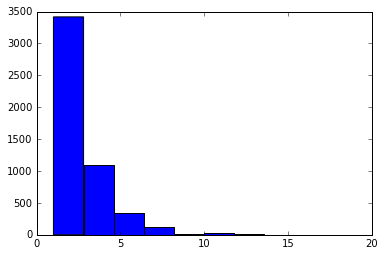

In [21]:
plt.hist(runs[0])

In [22]:
from scipy import stats

class Runs(object):
    '''class for runs in a binary sequence


    Parameters
    ----------
    x : array_like, 1d
        data array,


    Notes
    -----
    This was written as a more general class for runs. This has some redundant
    calculations when only the runs_test is used.

    TODO: make it lazy

    The runs test could be generalized to more than 1d if there is a use case
    for it.

    This should be extended once I figure out what the distribution of runs
    of any length k is.

    The exact distribution for the runs test is also available but not yet
    verified.

    '''

    def __init__(self, x):
        self.x = np.asarray(x)

        self.runstart = runstart = np.nonzero(np.diff(np.r_[[-np.inf], x, [np.inf]]))[0]
        self.runs = runs = np.diff(runstart)
        self.runs_sign = runs_sign = x[runstart[:-1]]
        self.runs_pos = runs[runs_sign==1]
        self.runs_neg = runs[runs_sign==0]
        self.runs_freqs = np.bincount(runs)
        self.n_runs = len(self.runs)
        self.n_pos = (x==1).sum()

    def runs_test(self, correction=True):
        '''basic version of runs test

        Parameters
        ----------
        correction: bool
            Following the SAS manual, for samplesize below 50, the test
            statistic is corrected by 0.5. This can be turned off with
            correction=False, and was included to match R, tseries, which
            does not use any correction.

        pvalue based on normal distribution, with integer correction

        '''
        self.npo = npo = (self.runs_pos).sum()
        self.nne = nne = (self.runs_neg).sum()

        #n_r = self.n_runs
        n = npo + nne
        npn = npo * nne
        rmean = 2. * npn / n + 1
        rvar = 2. * npn * (2.*npn - n) / n**2. / (n-1.)
        rstd = np.sqrt(rvar)
        rdemean = self.n_runs - rmean
        if n >= 50 or not correction:
            z = rdemean
        else:
            if rdemean > 0.5:
                z = rdemean - 0.5
            elif rdemean < 0.5:
                z = rdemean + 0.5
            else:
                z = 0.

        z /= rstd
        pval = 2 * stats.norm.sf(np.abs(z))
        return z, pval

In [23]:
runguy = Runs(follow)

In [24]:
runguy.runs_test()

(-12.314755543686507, 7.5443429318186841e-35)

In [25]:
len(runguy.runs_pos)

2512